An often used tool in my toolbox is polynomial regression to reduce smooth curves down to just a few best fit polynomial coefficients. These coefficients can then be used to do additional analysis that would have been difficult to do with the original (often patchily sampled) curves.

An important question then becomes, "how do I compare two polynomial curves?". It is tempting to use the euclidean distance between the coefficient vectors as a distance between polynomials. However, this (dis)similarity measure doesn't correspond very well to our intuitive understanding of the differences in shape between the corresponding curves.

<!-- TEASER_END --> 

In the past when I have searched for things like "distance between polynomials", "metrics on polynomial coefficient space", "similarity measures between polynomials", etc the search results have not been helpful. They tend to talk about things like using the ordered roots of a polynomial to represent it. A very intuitive sort of distance between two polynomials is the distance between the sampled curves. That is to say pick a grid of $N$ points $x_i$, evaluate the polynomials at those points $y_i = P(x_i)$ and then treat the resulting $y$ vectors as points in euclidean space $R^N$. But the quality of your results depends on the grid that you choose and actually carrying out this calculation can be very computationally expensive. Fortunately it turns out to not be too difficult to calculate the distance you would get in the analytic limit as $N \to \infty$ directly from the polynomial coefficients.

In [1]:
import numpy as np
np.random.seed(111222)
import scipy.spatial
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams.update(
    {
        "figure.figsize":(12, 6),
        "font.size":16,
    }
)

Consider the following set of polynomials on the interval -1 to 1.

Text(0,0.5,'Residual Magnitude')

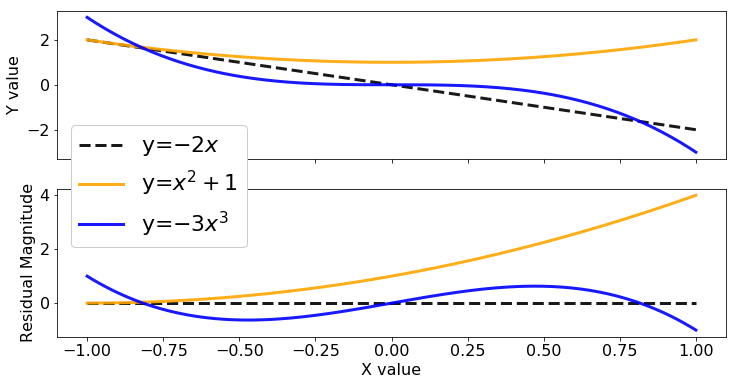

In [3]:
example_coeffs = np.array([
    [0, 0, -2, 0],
    [0, 1, 0, 1],
    [-3, 0, 0, 0],
])

poly_labels = ["-2x", "x^2+1", "-3x^3"]
colors = ["k", "orange", "blue"]
linestyles = ["--", "-", "-"]

x = np.linspace(-1, 1, 201)

yvals = [np.polyval(c, x) for c in example_coeffs]

fig, axes = plt.subplots(2, 1, sharex=True)

for y, label, color, ls in zip(yvals, poly_labels, colors, linestyles):
    axes[0].plot(x, y, lw=3, label="$y="+label+"$", c=color, linestyle=ls, alpha=0.9)
    axes[1].plot(x, y-yvals[0], lw=3, label="y=$"+label+"$", c=color, linestyle=ls, alpha=0.9)

    
legend = plt.legend(fontsize=22, bbox_to_anchor=(0.3, 1.5), framealpha=1.0)
axes[0].set_ylabel("Y value")
axes[1].set_xlabel("X value")
axes[1].set_ylabel("Residual Magnitude")

By looking at the curves I think most people would say that the cubic is much more similar to the line than the quadratic curve is. But the quadratic is significantly closer in coefficient space (a distance of $\sqrt{6}$ versus $\sqrt{13}$). 

You might think that I am cherry picking a special example and that in general the difference in coefficients will be a good predictor of the differences between the curves. Although the example above was chosen to be iullustrative it is in no way unusual. The distance in coefficient space is actually fairly loosely related to the distances between the associated curves. Lets pick a large set of polynomials with randomly distributed coefficients and compare the distances between the associated curves and the distances between the coefficient vectors.

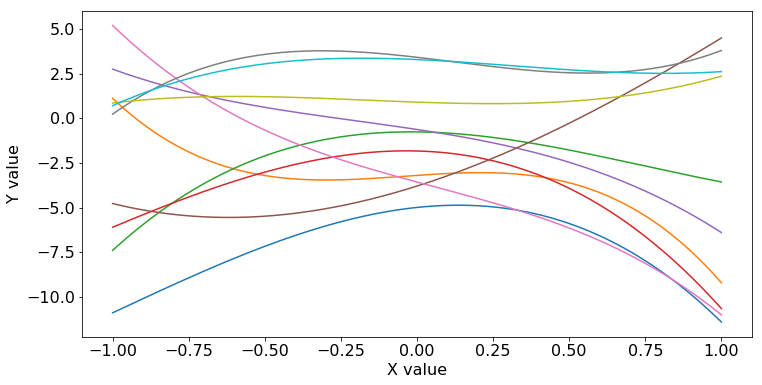

In [4]:
random_polys = 3.0*np.random.normal(size=(500, 4))
rand_yvals = np.array([np.polyval(c, x) for c in random_polys])

for i in range(10):
    plt.plot(x, rand_yvals[i])
    
plt.xlabel("X value")
plt.ylabel("Y value");

In [5]:
dx = np.mean(scipy.gradient(x))
curve_dists = dx*scipy.spatial.distance_matrix(rand_yvals, rand_yvals)
coeff_dists = scipy.spatial.distance_matrix(random_polys, random_polys)

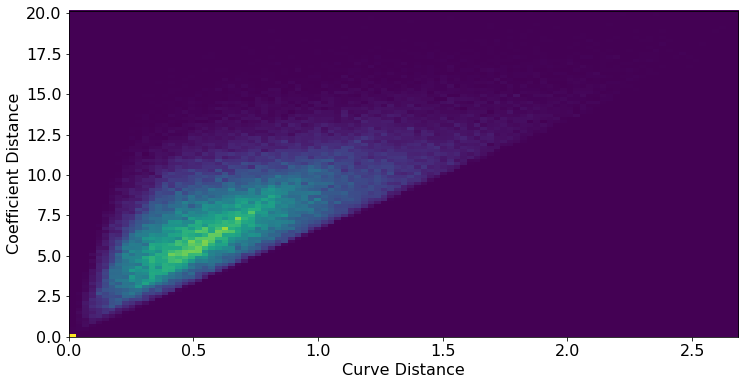

In [6]:
plt.hist2d(curve_dists.ravel(), coeff_dists.ravel(), 101)
plt.xlabel("Curve Distance")
plt.ylabel("Coefficient Distance");

Although it is clear that there is at least a fairly strong correlation between the distance in coefficient space and the distance in curve space there is an awful lot of leeway. In most situations it is the difference between the curves that really matters not the difference in coefficients. I think that the moral is clear, don't use the distance between the raw polynomial coefficients as a measure of similarity between the associated curves.


## A Little Linear Algebra

The problem with calculating distances in the polynomial coefficient space is that changes in different coefficients can have very similar looking effects on the shape of the curves. It isn't hard to tell the difference between $x$ and $x^2$ but if you squint $x^2$ and $x^4$ can look an awful lot alike. But it is possible to use a different sort of representation for our polynomials in which no two curves look too similar.

Lets come back to the concept of representing the polynomials as points in $R^N$. The polynomials of order $K$ will be a linear subspace of $R^N$. This true since any linear combination of polynomials is a polynomial (thus they are restricted to a linear subspace) and any polynomial can be expressed in the usual form.

$$
y(x) = \sum_{k=0}^{k=K} c_k x^k
$$ 


To use the language of linear algebra the monomials $x^k$ form a basis for the linear subspace of $R^{N}$ spanned by polynomial curves. If you are none too familiar with linear algebra, that may sound fancy but it is just a restatement of the fact that all polynomials can be expressed in the form above.

The observation that $x^2$ and $x^4$ "kinda look alike" can be made rigorous by considering the dot product of their corresponding sampled curves interpreted as points in $R^N$. It should be clear to see that the dot product in this case corresponds directly to the integral of the product of the two polynomials. The fact that these integrals don't tend to come out to 0 means that the usual polynomial basis functions $x^k$ aren't orthogonal to each other. 

This is exactly analogous to using a coordinate system in which the axes aren't at right angles to each other. In the usual case we pick a coordinate system in which each axis is orthonormal to all the others. If the coordinate basis is orthonormal then the distance between the coordinates is proportional to the distance between the corresponding points, which is rather handy. But this is true only if the coordinate axes are orthonormal to each other. If the coordinate axes aren't all at right angles to each other there is still always a unique coordinate label for any point, but, the distance between the labeled points is not necessarily equal (or even proportional) to the distance between the coordinate labels.

In this particular situation the polynomial coefficients are a set of "coordinates" which allow us to locate a polynomial within the subspace of all possible polynomials of a certain order. The coordinate axes are the basis functions $x^k$. But if you measure the angle in $R^n$ between these axes you often find that they are not quite perpendicular and this is what is causing us our distance based troubles. There is not really any reason why we must use the regular basis functions $x^k$ to express our polynomials. If we choose a set of basis functions which were all orthogonal to each other then distances in our coefficient space would correspond to the differences between the curves, success!

## Legendre Polynomials

It is one thing to say "just use an orthogonal polynomial basis!" but it is quite another to know how to go about doing that in practice. The first detail which must be dealt with is that it isn't possible to orthogonalize polynomials over every interval simultaneously. We need first to fix an interval in x and then we can set about finding a set of polynomials which are orthogonal to each other on that interval. 

As you might imagine this is a very old and well studied problem. Instead of needing to solve the orthogonalization problem afresh for each and every possible interval it is much more convenient to simply map whatever interval we desire onto the range $[-1, 1]$ and then always use the same set of orthogonal polynomials. 

Although there are a potentially infinite number of possible orthogonal polynomial bases one might choose. It is nice to pick the basis polynomials so that the order of the first polynomial is 0 the order of the second polynomial is 1, the order of the next is 2 and so on. With this additional constraint there turns out to be just one unique set of functions (up to a normalization constant) and those are the <a href=https://en.wikipedia.org/wiki/Legendre_polynomials>Legendre Polynomials</a>.

Conveniently there is a helper function in the numpy.polynomial module which will convert the coefficients of our polynomials from the usual coefficient space into a set of coefficients in an expansion over Legendre polynomials.

In [8]:
leg_coeffs = np.array([np.polynomial.legendre.poly2leg(c[::-1]) for c in random_polys])
leg_dists = scipy.spatial.distance_matrix(leg_coeffs, leg_coeffs)

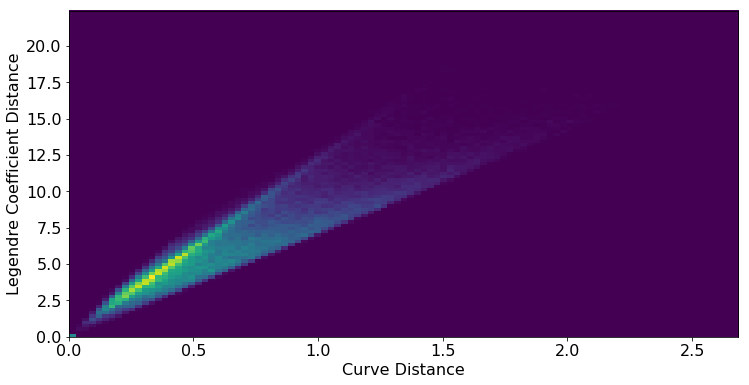

In [18]:
plt.hist2d(curve_dists.ravel(), leg_dists.ravel(), 101)
plt.xlabel("Curve Distance")
plt.ylabel("Legendre Coefficient Distance");

Hey what gives! I said that if the basis functions were orthonormal then the distance between the coefficients should be proportional to the distance between the curves. The distribution above may be a little better but it is still a far cry from exactly 1 to 1. 

One thing you might note in the code above is that when I do the conversion from the normal polynomial coefficients to the Legendre coefficients I flip the ordering of the coefficients first. This is because the polyval function which I use above comes from the old np.poly1d module which orders coefficients highest order first but the newer np.polynomial module (including the legendre routines) uses the opposite convention of ordering coefficients lowest order first. Blithely combinging functions from the poly1d module with the newer polynomial module expecting them to play nice is a bug which has bitten me on no small number of occaisions, be warned!

But the reason that the distances don't match up exactly is that the legendre polynomials as they have been implemented in numpy.polynomial are not actually orthonormal, only orthogonal. For reasons relating to other important properties of Legendre polynomials like recurrence relations etc, the polynomials all have different norms from each other.

In [11]:
np.std(np.polynomial.Legendre([0, 0, 0, 1])(x))

0.38369392722802725

Correcting for this problem is relatively straight forward we simply have to make sure that each Legendre coefficient gets a weight which is proportional to its norm.

In [33]:
#calculate the norms of each legendre polynomial
def rms(x):
    return np.sqrt(np.mean(x**2))

leg_norms = np.array([rms(np.polynomial.Legendre(v)(x)) for v in np.eye(4)])

In [34]:
leg_norms

array([ 1.        ,  0.58022984,  0.45169663,  0.38369393])

In [35]:
#rescale the coefficients by the corresponding basis norms
scaled_leg = leg_coeffs*leg_norms

In [36]:
scaled_dists = scipy.spatial.distance_matrix(scaled_leg, scaled_leg)

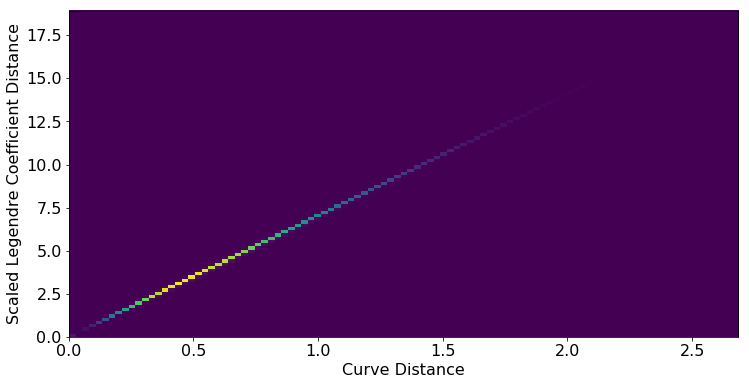

In [37]:
plt.hist2d(curve_dists.ravel(), scaled_dists.ravel(), 101)
plt.xlabel("Curve Distance")
plt.ylabel("Scaled Legendre Coefficient Distance");

Tada! a proper exact 1-1 relationship. 